In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

# Define the file path
file_path = 'mutual_fund_data/df_merged.csv'

# Read the DataFrame from the CSV file
dtype_spec = {
    'crsp_obj_cd': 'string',
    'si_obj_cd': 'string',
    'wbrger_obj_cd': 'string',
    'policy': 'string',
    'lipper_asset_cd': 'string',
    'lipper_class': 'string',
    'lipper_obj_cd': 'string'
}
df_merged = pd.read_csv(file_path, dtype=dtype_spec)

# Exclude rows where 'crsp_obj_cd' starts with 'I' or 'O'
excludes_i_o = ~df_merged['crsp_obj_cd'].str.startswith(('OM', 'OC', 'I'), na=False)

# Create a new DataFrame excluding the specified 'crsp_obj_cd' codes
df_merged = df_merged[excludes_i_o]
print(df_merged.shape)

# List of substrings to check for
# Appel et al 2016
substrings = [
    'Index', 'Idx', 'Indx', 'Ind ', 'Russell', 'S & P', 'S and P', 'S&P', 'SandP', 'SP ',
    'DOW', 'Dow', 'DJ', 'MSCI', 'Bloomberg', 'KBW', 'NASDAQ', 'NYSE', 'STOXX',
    'FTSE', 'Wilshire', 'Morningstar', '100', '400', '500', '600', '900', '1000',
    '1500', '2000', '5000'
]
print(df_merged.shape)
# Create the 'index' column
df_merged['index'] = df_merged['fund_name'].str.contains('|'.join(substrings), case=False).astype(int)


# df_merged = df_merged[~((df_merged['index_fund_flag'] == 'D') | (df_merged['index'] == 1))]

# conditions_active = (
#     (df_merged['index_fund_flag'].isin(['B', 'E'])) &
#     (df_merged['index'] == 0)
# )
conditions_active = (
    (df_merged['index'] == 0)
)

# conditions_passive = (
#     (df_merged['index_fund_flag'] == 'D') |
#     (df_merged['index'] == 1)
# )
conditions_passive = (
    (df_merged['index'] == 1)
)



# Initialize fund type to 'Other', then set to 'Active' or 'Passive' based on conditions
df_merged['fund_type'] = 'Other'
df_merged.loc[conditions_active, 'fund_type'] = 'Active'
df_merged.loc[conditions_passive, 'fund_type'] = 'Passive'

# Split the DataFrame into active, passive, and other
active_funds = df_merged[df_merged['fund_type'] == 'Active']
passive_funds = df_merged[df_merged['fund_type'] == 'Passive']
other_funds= df_merged[df_merged['fund_type'] == 'Other']

# Display the results
print("Active Funds:")
print(active_funds.shape)

print("\nPassive Funds:")
print(passive_funds.shape)

# There are no other Funds

(4134876, 68)
(4134876, 68)
Active Funds:
(3741980, 70)

Passive Funds:
(392896, 70)


In [2]:
# # Calculate average value added in the second half of the observations by year
# df_merged['caldt'] = pd.to_datetime(df_merged['caldt'])

# def calculate_second_half_avg(group):
#     n = len(group)
#     half_n = n // 2
#     if half_n > 1:
#         second_half = group.iloc[half_n:]
#         return second_half.groupby(second_half['caldt'].dt.year)['vanguard_VA'].mean()
#     else:
#         return pd.Series()

# value_added_2nd_half = df_merged.groupby('crsp_fundno').apply(calculate_second_half_avg).reset_index()

# # Rename columns for merging
# value_added_2nd_half.columns = ['crsp_fundno', 'year', 'avg_value_added_2nd_half']

# # Merge the average value added by year to the main DataFrame
# df_merged = df_merged.merge(value_added_2nd_half, on=['crsp_fundno', 'year'], how='left')

# df_merged = df_merged.dropna(subset=['skill_ratio'])

# # Now decile on skill ratio
# deciles = pd.qcut(df_merged['skill_ratio'], 3, labels=False)
# df_merged['skill_ratio_decile'] = deciles

# # Group by year and decile and calculate the mean avg_value_added_2nd_half
# decile_yearly_avg_value_added = df_merged.groupby(['year', 'skill_ratio_decile'])['avg_value_added_2nd_half'].mean().unstack()

# # Plot the results
# plt.figure(figsize=(12, 8))
# for decile in decile_yearly_avg_value_added.columns:
#     plt.plot(decile_yearly_avg_value_added.index, decile_yearly_avg_value_added[decile], marker='o', label=f'Decile {decile + 1}')

# plt.title('Average Value Added in Second Half by Skill Ratio Decile and Year')
# plt.xlabel('Year')
# plt.ylabel('Average Value Added')
# plt.legend(title='Skill Ratio Decile')
# plt.grid(False)
# plt.show()

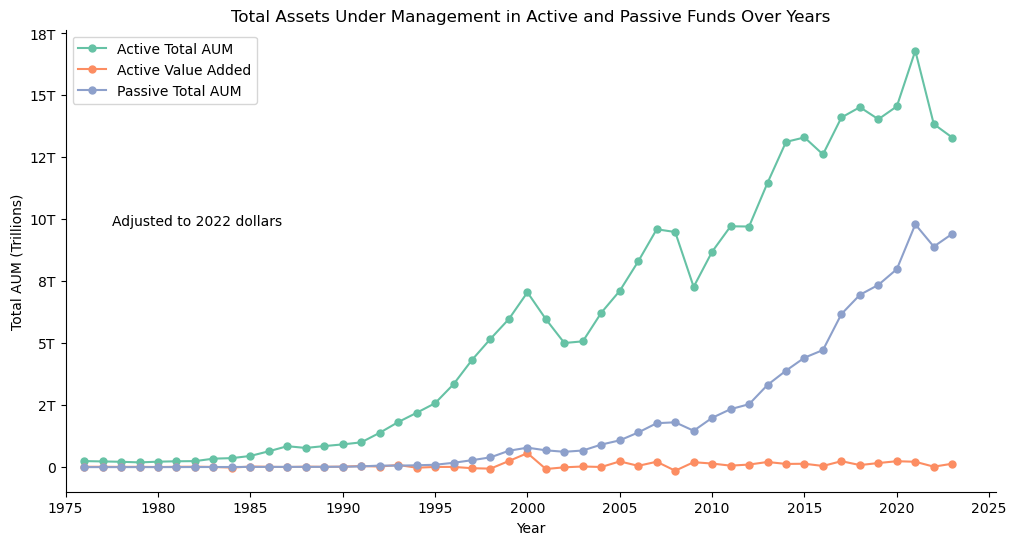

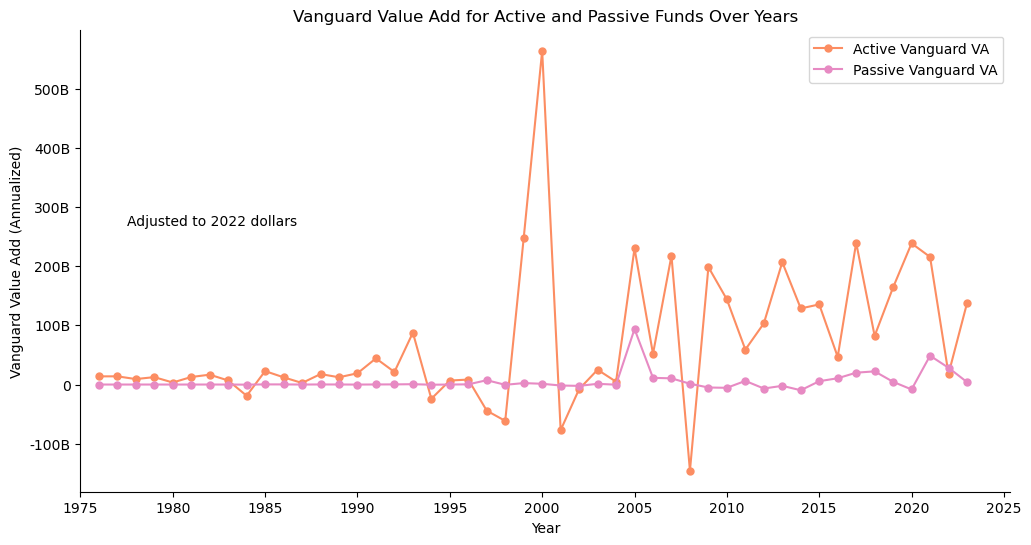

In [3]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

palette = sns.color_palette("Set2")
colors = {
    'active_aum': palette[0],
    'active_va': palette[1],
    'passive_aum': palette[2],
    'passive_va': palette[3],
    'other_aum': palette[4],
    'other_va': palette[5],
}

# Assuming df_merged is already created, read, and processed as described in your previous steps.

# Separate the data into active and passive funds
active_funds = df_merged[df_merged['fund_type'] == 'Active']
passive_funds = df_merged[df_merged['fund_type'] == 'Passive']

# Calculate metrics for active funds
num_active_funds = active_funds.groupby('year')['crsp_fundno'].nunique()
mean_active_assets_per_fund = active_funds.groupby('year')['mtna_adj2022'].mean()
active_ff_VA = active_funds.groupby('year')['ff_VA'].mean()
active_vanguard_VA = active_funds.groupby('year')['vanguard_VA'].mean()

active_df_by_year = pd.DataFrame({
    'num_funds_each_year': num_active_funds,
    'mean_assets_per_fund': mean_active_assets_per_fund,
    'ff_monthly_mean_VA': active_ff_VA,
    'vanguard_monthly_mean_VA': active_vanguard_VA
}).reset_index()

active_df_by_year['total_aum_in_funds'] = active_df_by_year['num_funds_each_year'] * active_df_by_year['mean_assets_per_fund'] * 1000000
active_df_by_year['ff_VA_tot'] = active_df_by_year['ff_monthly_mean_VA'] * 12 * active_df_by_year['num_funds_each_year']
active_df_by_year['vanguard_VA_tot'] = active_df_by_year['vanguard_monthly_mean_VA'] * 12 * active_df_by_year['num_funds_each_year']

# Calculate metrics for passive funds
num_passive_funds = passive_funds.groupby('year')['crsp_fundno'].nunique()
mean_passive_assets_per_fund = passive_funds.groupby('year')['mtna_adj2022'].mean()
passive_ff_VA = passive_funds.groupby('year')['ff_VA'].mean()
passive_vanguard_VA = passive_funds.groupby('year')['vanguard_VA'].mean()

passive_df_by_year = pd.DataFrame({
    'num_funds_each_year': num_passive_funds,
    'mean_assets_per_fund': mean_passive_assets_per_fund,
    'ff_monthly_mean_VA': passive_ff_VA,
    'vanguard_monthly_mean_VA': passive_vanguard_VA
}).reset_index()

passive_df_by_year['total_aum_in_funds'] = passive_df_by_year['num_funds_each_year'] * passive_df_by_year['mean_assets_per_fund'] * 1000000
passive_df_by_year['ff_VA_tot'] = passive_df_by_year['ff_monthly_mean_VA'] * 12 * passive_df_by_year['num_funds_each_year']
passive_df_by_year['vanguard_VA_tot'] = passive_df_by_year['vanguard_monthly_mean_VA'] * 12 * passive_df_by_year['num_funds_each_year']


# Calculate metrics for other funds
num_other_funds = other_funds.groupby('year')['crsp_fundno'].nunique()
mean_other_assets_per_fund = other_funds.groupby('year')['mtna_adj2022'].mean()
other_ff_VA = other_funds.groupby('year')['ff_VA'].mean()
other_vanguard_VA = other_funds.groupby('year')['vanguard_VA'].mean()

other_df_by_year = pd.DataFrame({
    'num_funds_each_year': num_other_funds,
    'mean_assets_per_fund': mean_other_assets_per_fund,
    'ff_monthly_mean_VA': other_ff_VA,
    'vanguard_monthly_mean_VA': other_vanguard_VA
}).reset_index()

other_df_by_year['total_aum_in_funds'] = other_df_by_year['num_funds_each_year'] * other_df_by_year['mean_assets_per_fund'] * 1000000
other_df_by_year['ff_VA_tot'] = other_df_by_year['ff_monthly_mean_VA'] * 12 * other_df_by_year['num_funds_each_year']
other_df_by_year['vanguard_VA_tot'] = other_df_by_year['vanguard_monthly_mean_VA'] * 12 * other_df_by_year['num_funds_each_year']

# Define billions and trillions formatters
def billions(x, pos):
    if x == 0:
        return '0'
    return f'{x * 1e-9:.0f}B'  # convert to billions

def trillions(x, pos):
    if x == 0:
        return '0'
    else:
        return f'{x * 1e-12:.0f}T'

# Create formatter
formatter = FuncFormatter(trillions)

# Plot AUM for Active and Passive funds by year
plt.figure(figsize=(12, 6))
plt.plot(active_df_by_year['year'], active_df_by_year['total_aum_in_funds'], marker='o', markersize=5, label="Active Total AUM", color=colors['active_aum'])
plt.plot(active_df_by_year['year'], active_df_by_year['vanguard_VA_tot'], marker='o', markersize=5, label="Active Value Added", color=colors['active_va'])
plt.plot(passive_df_by_year['year'], passive_df_by_year['total_aum_in_funds'], marker='o', markersize=5, label="Passive Total AUM", color=colors['passive_aum'])
plt.title('Total Assets Under Management in Active and Passive Funds Over Years')
plt.xlabel('Year')
plt.ylabel('Total AUM (Trillions)')
plt.gca().yaxis.set_major_formatter(formatter)  # apply formatter
plt.text(0.05, 0.6, 'Adjusted to 2022 dollars', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=None)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(range(1965, 2026, 5))
ax.set_xlim(left=1975)
plt.grid(False)
plt.legend()
plt.savefig('figures/active_passive_aum.pdf')
plt.show()
formatter = FuncFormatter(billions)

# Plot Vanguard Value Add for Active and Passive funds by year
plt.figure(figsize=(12, 6))
plt.plot(active_df_by_year['year'], active_df_by_year['vanguard_VA_tot'], marker='o', markersize=5, label="Active Vanguard VA", color=colors['active_va'])
plt.plot(passive_df_by_year['year'], passive_df_by_year['vanguard_VA_tot'], marker='o', markersize=5, label="Passive Vanguard VA", color=colors['passive_va'])

plt.title('Vanguard Value Add for Active and Passive Funds Over Years')
plt.xlabel('Year')
plt.ylabel('Vanguard Value Add (Annualized)')
plt.text(0.05, 0.6, 'Adjusted to 2022 dollars', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=None)
plt.gca().yaxis.set_major_formatter(formatter)  # apply formatter

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(range(1965, 2026, 5))
ax.set_xlim(left=1975)
plt.grid(False)
plt.legend()
plt.savefig('figures/active_passive_vanguard_va.pdf')
plt.show()

In [4]:
"""df_merged.sort_values(by=['crsp_fundno', 'caldt'], inplace=True)

# Define a function to compute the skill ratio for the first 50% observations of each fund
def compute_skill_ratio(group):
    n = len(group)
    half_n = n // 2  # Get the first 50% of the observations
    
    # Ensure there are enough observations to compute the ratio
    if half_n > 1:
        first_half = group.iloc[:half_n]
        mean_vanguard_VA = first_half['vanguard_VA'].mean()
        std_vanguard_VA = first_half['vanguard_VA'].std()
        
        if std_vanguard_VA != 0:
            skill_ratio = mean_vanguard_VA / std_vanguard_VA
        else:
            print(group)
            skill_ratio = np.nan

        return pd.Series({'skill_ratio': skill_ratio})
    else:
        return pd.Series({'skill_ratio': np.nan})

# Group the DataFrame by crsp_fundno and apply the skill ratio computation
skill_ratios = df_merged.groupby('crsp_fundno').apply(compute_skill_ratio).reset_index()

# Merge the skill ratios back to the original DataFrame
df_merged = df_merged.merge(skill_ratios, on='crsp_fundno', how='left')"""

"df_merged.sort_values(by=['crsp_fundno', 'caldt'], inplace=True)\n\n# Define a function to compute the skill ratio for the first 50% observations of each fund\ndef compute_skill_ratio(group):\n    n = len(group)\n    half_n = n // 2  # Get the first 50% of the observations\n    \n    # Ensure there are enough observations to compute the ratio\n    if half_n > 1:\n        first_half = group.iloc[:half_n]\n        mean_vanguard_VA = first_half['vanguard_VA'].mean()\n        std_vanguard_VA = first_half['vanguard_VA'].std()\n        \n        if std_vanguard_VA != 0:\n            skill_ratio = mean_vanguard_VA / std_vanguard_VA\n        else:\n            print(group)\n            skill_ratio = np.nan\n\n        return pd.Series({'skill_ratio': skill_ratio})\n    else:\n        return pd.Series({'skill_ratio': np.nan})\n\n# Group the DataFrame by crsp_fundno and apply the skill ratio computation\nskill_ratios = df_merged.groupby('crsp_fundno').apply(compute_skill_ratio).reset_index()\n\n

In [5]:
"""df_merged[~df_merged['skill_ratio'].isna()]"""

"df_merged[~df_merged['skill_ratio'].isna()]"

In [6]:
for i in passive_funds[passive_funds['year'] == 2005].sort_values(by='vanguard_VA', ascending=False).head(10)['fund_name']:
    print(i)

iShares Trust: iShares MSCI EAFE  Index Fund
iShares Trust: iShares Russell 2000 Index Fund
iShares Trust: iShares Russell 2000 Value Index Fund
iShares Trust: iShares S&P MidCap 400 Index Fund
iShares Trust: iShares Cohen & Steers Realty Majors Index Fund
streetTRACKS Series Trust: streetTRACKS Wilshire REIT Index Fund
iShares Trust: iShares Dow Jones US Real Estate Index Fund
iShares Trust: iShares Goldman Sachs Natural Resources Index Fund
iShares Trust: iShares MSCI EAFE  Index Fund
iShares, Inc: iShares MSCI Japan Index Fund


In [7]:
passive_funds['exp_ratio'].mean()

0.0062815385567681955

In [8]:
active_funds['exp_ratio'].mean()

0.011634469647619699

In [9]:
def find_matching_substrings(fund_name, substrings):
    return [substring for substring in substrings if substring.lower() in fund_name.lower()]
find_matching_substrings('AIM Funds Group: AIM Premier Equity Fund; Class B Shares', substrings)

[]

In [10]:
for i in active_funds[active_funds['year'] == 2000].sort_values(by='vanguard_VA', ascending=False).head(10)['fund_name']:
    print(i)

AIM Funds Group: AIM Premier Equity Fund; Class B Shares
AIM Funds Group: AIM Premier Equity Fund; Class A Shares
AIM Equity Funds, Inc.: AIM Aggressive Growth Fund; Class A Shares
John Hancock Series Trust: John Hancock Technology Fund; Class B Shares
John Hancock Series Trust: John Hancock Technology Fund; Class A Shares
AIM Funds Group: AIM Premier Equity Fund; Class B Shares
Rydex Series Funds: OTC Fund; Investor Shares
AIM Funds Group: AIM Premier Equity Fund; Class A Shares
Savos Investments Trust: Savos Dynamic Hedging Fund
Savos Investments Trust: Savos Dynamic Hedging Fund
